In [44]:
# Cell 1: Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from sbi import utils
from sbi.inference import SNPE
from sbi.utils.get_nn_models import posterior_nn
import pandas as pd

# Constants
c = 299792.458  # speed of light in km/s

In [45]:
# Cell 2: Physics functions
def H(z, theta):
    """Hubble parameter at redshift z"""
    H0, Om = theta[:, 0], theta[:, 1]
    OL = 1 - Om  # Flat universe: Omega_Lambda = 1 - Omega_m
    return H0[:, None] * torch.sqrt(torch.clamp(Om[:, None] * (1 + z)**3 + OL[:, None], min=1e-10))

def luminosity_distance(z, theta):
    """Calculate luminosity distance in Mpc"""
    N = 1000  # number of points
    z_array = torch.linspace(0, z.max(), N)
    dz = z_array[1] - z_array[0]
    
    # Calculate integrand values for all theta at once
    integrand_values = c / H(z_array, theta)  # shape: [num_theta, N]
    
    # Cumulative sum for integration
    chi = torch.cumsum(integrand_values * dz, dim=1)  # shape: [num_theta, N]
    
    # Linear interpolation for each parameter set
    chi_interp = torch.zeros(theta.shape[0], len(z))
    for i in range(len(z)):
        # Find indices for interpolation
        idx = torch.searchsorted(z_array, z[i])
        idx = torch.clamp(idx, 1, N-1)
        
        # Get surrounding points
        z0, z1 = z_array[idx-1], z_array[idx]
        chi0, chi1 = chi[:, idx-1], chi[:, idx]
        
        # Linear interpolation
        w = (z[i] - z0) / (z1 - z0)
        chi_interp[:, i] = chi0 * (1 - w) + chi1 * w
    
    # For flat universe, comoving distance equals proper distance
    return torch.clamp((1 + z) * chi_interp, min=1e-10)


In [46]:
# Cell 3: Simulator
def simulator(theta):
    """Simulator function that takes parameters and returns distance moduli"""
    # Load data (we need the redshifts)
    df = pd.read_csv('Pantheon+SH0ES.dat', sep='\s+', header=0)
    z = torch.tensor(df['zHD'].values, dtype=torch.float32)
    
    # Calculate distance modulus
    dL = luminosity_distance(z, theta)
    mu = 5 * torch.log10(torch.clamp(dL, min=1e-10)) + 25
    
    # Add observational noise
    sigma = torch.tensor(df['MU_SH0ES_ERR_DIAG'].values, dtype=torch.float32)
    mu += torch.randn_like(mu) * sigma[None, :]
    
    return mu

In [47]:
# Cell 4: Neural Network Definition
def create_neural_net(num_features):
    """Create a custom neural network for the posterior estimation"""
    embedding_net = torch.nn.Sequential(
        torch.nn.Linear(num_features, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 16)
    )
    
    return posterior_nn(
        model='maf',  # Masked Autoregressive Flow
        hidden_features=50,  # Number of hidden units per layer
        num_transforms=5,    # Number of MAF transforms
        num_blocks=2,        # Number of hidden layers per transform
        embedding_net=embedding_net
    )

In [48]:
# Cell 5: Setup and Training
# Define prior
prior = utils.BoxUniform(
    low=torch.tensor([60.0, 0.1]),  # H0, Om
    high=torch.tensor([80.0, 0.9])
)

# Load data to get number of features
df = pd.read_csv('Pantheon+SH0ES.dat', sep='\s+', header=0)
num_features = len(df['MU_SH0ES'].values)

# Create inference object
inference = SNPE(
    prior=prior, 
    density_estimator=create_neural_net(num_features)
)

# Generate training data
num_simulations = 50000
theta = prior.sample((num_simulations,))
x = simulator(theta)

# Train the neural network
density_estimator = inference.append_simulations(theta, x).train(
    training_batch_size=1000,     
    max_num_epochs=2000,          
    show_train_summary=True,
    validation_fraction=0.1,
    stop_after_epochs=20,         
    learning_rate=5e-4
)
posterior = inference.build_posterior(density_estimator)

/var/folders/yv/1fmjzcsn6xs23xrlfnvvd82w0000gn/T/ipykernel_90097/3099565414.py:12: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  return posterior_nn(


 Neural network successfully converged after 41 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 41
        Best validation performance: -2.0065
        -------------------------
        


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

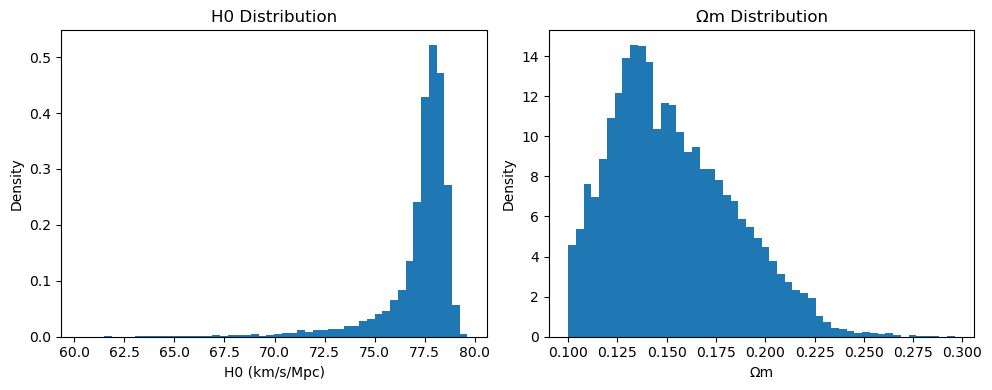

Inferred Parameters:
H0: 77.20 ± 1.89
Ωm: 0.15 ± 0.03
ΩΛ: 0.85 ± 0.03


In [51]:
# Cell 6: Inference and Plotting
# Load real data
x_o = torch.tensor(df['MU_SH0ES'].values, dtype=torch.float32)

# Sample from posterior
samples = posterior.sample((10000,), x=x_o)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(samples[:, 0].numpy(), bins=50, density=True)
ax1.set_xlabel('H0 (km/s/Mpc)')
ax1.set_ylabel('Density')
ax1.set_title('H0 Distribution')

ax2.hist(samples[:, 1].numpy(), bins=50, density=True)
ax2.set_xlabel('Ωm')
ax2.set_ylabel('Density')
ax2.set_title('Ωm Distribution')

plt.tight_layout()
plt.show()

# Print results
print("Inferred Parameters:")
print(f"H0: {samples[:, 0].mean():.2f} ± {samples[:, 0].std():.2f}")
print(f"Ωm: {samples[:, 1].mean():.2f} ± {samples[:, 1].std():.2f}")
print(f"ΩΛ: {1-samples[:, 1].mean():.2f} ± {samples[:, 1].std():.2f}")